In [1]:
import csv
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [18]:
# Importing dataset
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Attributes of dataset:'Date', 'Open', 'High', 'Low', 'Close', 'Volume (BTC)', Volume (Currency)', 'Weighted Price'

with open("BTC_data.csv") as csvfile:
    reader = list(csv.reader(csvfile))[1::]
    pre_data = delete(reader, [0, 2, 3, 5,  6], axis=1) # we remove the Date, High, Low and Volumes
    d = []
    for day in pre_data:
        day_to_add = []
        for element in day:
            day_to_add.append(float(element))
        if mean(day_to_add) != 0.0:
            d.append(day_to_add)
    
data = flip(array(d), axis = 0)

# Features: Open, Close, Weighted price


In [20]:
# CREATING LABELS
from collections import Counter

# We create labels based on the increase or decrease per day, which is what we want to predict
# We discretize the labels in 5 classes: stable, small / big increase / decrease
# Also try to have a binary label since the results were not as we expected. 
data_labels = []
for day in data[1:]:
    y = (day[1]-day[0]) / day[1]
    if y >= 0:
        data_labels.append(1)
    elif y < 0:
        data_labels.append(0)

data_labels.append(1) # since we want to predict the change on T = t+1 using the features in T = t

labels = array(data_labels)


print(Counter(labels))
print("len", len(labels))

Counter({1: 1293, 0: 962})
('len', 2255)


In [21]:
# ADD PERCENTUAL CHANGES PER DAY AS A FEATURE
changes = []
for day in data:
    changes.append(100*(day[1]-day[0]) / day[1])
    
data_inc = c_[data, array(changes)]

# Features: Open, Close, Weighted price, Change

In [22]:
# CREATE MOVING AVERAGES FEATURES

MA5 = [0,0,0,0,0]
for day in range(5, len(data)):
    m_a5 = array(mean(data[day - 5 : day], axis=0)[-1])
    MA5.append(m_a5)


MA15 = 15 * [1]
for day in range(15, len(data)):
    m_a15 = mean(data[day - 15 : day], axis=0)[-1]
    MA15.append(m_a15)


MA_fraction = 15 * [0] + [x / y for x, y in zip(MA5[15:], MA15[15:])]
data_MA = c_[data_inc, array(MA_fraction)][:]

# DELETE OPEN AND CLOSING PRICE AS FEATURES
data = delete(data_MA, [0,1], axis = 1)


# Features: Weighted price, Change, ratio_MA
    

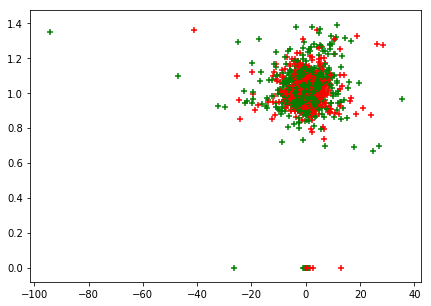

In [28]:
plt.figure(1, figsize=(7, 5))
for i in range(len(data)):
    label = labels[i]
    d = data[i]
    if label == 0:
        plt.scatter(d[1], d[2], marker='+', color='red')
    else:
        plt.scatter(d[1], d[2], marker='+', color='green')
plt.show()

In [6]:
# SPLITTING DATA ADN TRAINING CLASSIFIERS
from sklearn.model_selection import train_test_split 

# We split the data sequentially into a train and test set
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, shuffle=False)

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Normalize the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)


# LOGISTIC REGRESSION
LR = LogisticRegression()
LR.fit(X_train, y_train)
LR_predictions = LR.predict(X_test)
LR_CV_score = cross_val_score(LR, X_train, y_train, cv=3)
LR_accuracy = accuracy_score(y_test, LR_predictions)
print("Test set accuracy:", LR_accuracy, "\ncv", LR_CV_score)

print(confusion_matrix(y_pred=LR_predictions, y_true=y_test))
print(classification_report(y_pred=LR_predictions, y_true=y_test))

('Test set accuracy:', 0.39246119733924612, '\ncv', array([ 0.55647841,  0.56312292,  0.53      ]))
[[177   0]
 [274   0]]
             precision    recall  f1-score   support

          0       0.39      1.00      0.56       177
          1       0.00      0.00      0.00       274

avg / total       0.15      0.39      0.22       451



/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [8]:
# NEURAL NETWORKS
from sklearn.neural_network import MLPClassifier

# For the neural networks it is important to use normalized data
MLP = MLPClassifier(max_iter=1000)
MLP.fit(X_train, y_train)
MLP_predictions = MLP.predict(X_test)
MLP_CV_score = cross_val_score(MLP, X_train, y_train, cv=5)
MLP_accuracy = accuracy_score(y_test, MLP_predictions)
print("Test set accuracy:", MLP_accuracy, "\ncv", MLP_CV_score)

print(confusion_matrix(y_pred=MLP_predictions, y_true=y_test))
print(classification_report(y_pred=MLP_predictions, y_true=y_test))
# score with default data: 
# Test set accuracy: 0.39689578714 
# cv [ 0.20936639  0.27900552  0.4265928   0.39722222  0.40502793]


('Test set accuracy:', 0.60753880266075388, '\ncv', array([ 0.56509695,  0.57063712,  0.63434903,  0.43490305,  0.43611111]))
[[  0 177]
 [  0 274]]
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       177
          1       0.61      1.00      0.76       274

avg / total       0.37      0.61      0.46       451



In [9]:
# Decision Tree and Randomforests
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# Decision Tree
DTC = DecisionTreeClassifier()
DTC.fit(X_train, y_train)
DTC_predictions = DTC.predict(X_test)
DTC_CV_score = cross_val_score(DTC, X_train, y_train, cv=5)
DTC_accuracy = accuracy_score(y_test, DTC_predictions)
print("DTC\nTest set accuracy:", DTC_accuracy, "\ncv", DTC_CV_score)

print(confusion_matrix(y_pred=DTC_predictions, y_true=y_test))
print(classification_report(y_pred=DTC_predictions, y_true=y_test))

# Random forest
RF = RandomForestClassifier()
RF.fit(X_train, y_train)
RF_predictions = RF.predict(X_test)
RF_CV_score = cross_val_score(RF, X_train, y_train, cv=5)
RF_accuracy = accuracy_score(y_test, RF_predictions)
print("RF\nTest set accuracy:", RF_accuracy, "\ncv", RF_CV_score)

print(confusion_matrix(y_pred=RF_predictions, y_true=y_test))
print(classification_report(y_pred=RF_predictions, y_true=y_test))

('DTC\nTest set accuracy:', 0.42793791574279377, '\ncv', array([ 0.57617729,  0.21883657,  0.32963989,  0.44598338,  0.51111111]))
[[105  72]
 [186  88]]
             precision    recall  f1-score   support

          0       0.36      0.59      0.45       177
          1       0.55      0.32      0.41       274

avg / total       0.48      0.43      0.42       451

('RF\nTest set accuracy:', 0.42350332594235035, '\ncv', array([ 0.56509695,  0.2299169 ,  0.29362881,  0.47091413,  0.475     ]))
[[153  24]
 [236  38]]
             precision    recall  f1-score   support

          0       0.39      0.86      0.54       177
          1       0.61      0.14      0.23       274

avg / total       0.53      0.42      0.35       451



In [10]:
from sklearn import svm
SVM = svm.SVC()
SVM.fit(X_train_norm, y_train)
SVM_predictions = SVM.predict(X_test_norm)
SVM_CV_score = cross_val_score(SVM, X_train_norm, y_train, cv=5)
SVM_accuracy = accuracy_score(y_test, SVM_predictions)
print("SVM\nTest set accuracy:", SVM_accuracy, "\ncv", SVM_CV_score)

print(confusion_matrix(y_pred=SVM_predictions, y_true=y_test))
print(classification_report(y_pred=SVM_predictions, y_true=y_test))

('SVM\nTest set accuracy:', 0.56097560975609762, '\ncv', array([ 0.56509695,  0.56509695,  0.5567867 ,  0.4598338 ,  0.49166667]))
[[ 55 122]
 [ 76 198]]
             precision    recall  f1-score   support

          0       0.42      0.31      0.36       177
          1       0.62      0.72      0.67       274

avg / total       0.54      0.56      0.55       451



In [11]:
# make graphs comparing the predictions and the real prices

In [12]:
# Plotting

plt.figure(1, figsize=(7, 5))
for i in range(len(data)):
    v = log10(d[i][5])
    plt.scatter(i, v, marker='+', color='black')
plt.show()

plt.figure(1, figsize=(7, 5))
for i in range(len(data)):
    v = d[i][5]
    plt.scatter(i, v, marker='+', color='black')
plt.show()

plt.figure(1, figsize=(7, 5))
for i in range(15, len(data)):
    w = d[i][-1]
    plt.scatter(i, w, marker='+', color='black')
plt.show()

IndexError: list index out of range